https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

## Load library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv, pd.to_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input/ieee-fraud-detection"))

## Data sets

In [ ]:
DATA_PATH = '../input/ieee-fraud-detection'

df_id = pd.read_csv(os.path.join(DATA_PATH, 'train_identity.csv'))
df_trans = pd.read_csv(os.path.join(DATA_PATH, 'train_transaction.csv'))

In [ ]:
df_trans.head()

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [ ]:
## Reducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

## Knowing the data

In [ ]:
resumetable(df_trans)[:25]

## Target Distribution

In [ ]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16, 6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud#", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel("Count", fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total*100),
           ha = 'center', fontsize=15)
    
perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()

plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt', dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel("Total Transaction Amount Scalar", fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()             

We have 3.5% of Fraud transactions in our data set.
I think that it would be interesting to see if the amount percentual is higher or lower than 3.5% of total. I will see it later.
We have the same % when considering the Total Transactions Amount by Fraud and No Fraud. Let's explore the Transaction amount further below.

## Transaction Amount Quantiles(거래 금액)

Before Ploting the Transaction Amount, Let's see the quantiles of Transaction Amount

In [ ]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

## Ploting Transaction Amount Values Distribution(거래 금액 분포 표시)

In [ ]:
plt.figure(figsize=(16, 12))
plt.suptitle('Transaction Values Distribution', fontsize=22)

plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribution <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribution", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16, 12))


plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
                 label = 'NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
                 label = 'Fraud', alpha=.2)
g4 = plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16, 12))

plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
                label = 'isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

## Seeing the Quantiles of Fraud and No Fraud Transactions

In [ ]:
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(),
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                 axis=1, keys=['Fraud', 'No Fraud']))

## Transaction Amount Outliers

- It's considering outlier values that are highest than 3 times the std from the mean

In [ ]:
CalcOutliers(df_trans['TransactionAmt'])

If we consider only values between >= 0 to 800 we will avoid the outliers and has more confidence in our distribution.
We have 10k rows with outliers that represents 1.74% of total rows.

### Now, let's known the Product Feature

- Distribution Products
- Distribution of Frauds by Product
- Has Difference between Transaction Amounts in Products?

In [ ]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

W, C and R are the most freqent values. <br>
We can note that in W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transactions.

## Card Features

- Based on Competition Description, card features are categoricals.
- Let's understand the distribution of values.
- What's the different in transactions and % of Fraud for each values in these features.
- Card features has 6 columns, and 4 of them seems to be numericals, so let's see the quantiles and distributions.

In [ ]:
## Knowning the Card Features
resumetable(df_trans[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']])

Card2 - Card6 has some missing values. We will need to due with it later.

## Numericals Feature Card Quantiles

In [ ]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

We can see that Card1 and Card2 has a large distribution of values, so maybe it will be better to get the log of these columns.

In [ ]:
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index), 'card3'] = "Others"
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index), 'card5'] = "Others"

## Visualizing Card1, Card2 and Card3 Distributions

- As the Card1 and 2 are numericals, I will plot the distribution of them.
- in Card3, as we have many values with low frequencies, I decided to set value to "Others"
- Also, in Card3 I set the % of Fraud ratio in yaxis2

In [ ]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

Cool and Very Meaningful information. 
In Card3 we can see that 100 and 106 are the most common values in the column. 
We have 4.95% of Frauds in 100 and 1.52% in 106; The values with highest Fraud Transactions are 185, 119 and 119; 

In card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also is possible to see high % of frauds in 137, 147, 141 that has few entries for values.

## Card4 - Categorical

In [ ]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

We can see that 97% of our data are in Mastercard(32%) and Visa(65%);
we have a highest value in discover(~8%) against ~ 3.5% of Mastercard and Visa and 2.87% in American Express

## Card6 - Categorical

In [ ]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

## Exploring M1-M9 Features

In [ ]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

### M distributions: Count, %Fraud and Transaction Amount distribution

In [ ]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8','M9']:
    ploting_dist_ratio(df_trans, col, lim=2500)

Very cool~! This graphs give us many interesting intuition about the M features.
Only in M4 the Missing values haven't the highest % of Fraud.

## Addr1 and Addr2

In [ ]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, 0.25, .1, .25, .5, .75, .90, .975, .99]))

I will set all values in Addr1 that has less than 5000 entries to "Other"
In Addr2 I will set as "Others" all values with less than 50 entries

In [ ]:
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 5000].index), 'addr1'] = "Others"
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 50].index), 'addr2'] = "Others"

### Addr1 Distributions

In [ ]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')

We can note interesting patterns on Addr1.

### Addr2 Distributions

In [ ]:
ploting_cnt_amt(df_trans, 'addr2')

Almost all entries in Addr2 are in the same value. 
Interestingly in the value 65 , the percent of frauds are almost 60% 
Altought the value 87 has 88% of total entries, it has 96% of Total Transaction Amounts

## P emaildomain Distributions

- I will group all e-mail domains by the respective enterprises.
- Also, I will set as "Others" all values with less than 500 entries.

In [ ]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com', 'gmail']), 'P_emaildomain'] = 'Google'
df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de', 'yahoo.fr', 'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 500].index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

### Ploting P-Email Domain

In [ ]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

### R-Email Domain plot distribution
- I will group all e-mail domains by the respective enterprises.
- I will set as "Others" all values with less than 300 entries.

In [ ]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

In [ ]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

We can see a very similar distribution in both email domain features.
It's interesting that we have high values in google and icloud frauds.

## C1-C14 features

- Let's understand what this features are.
- What's the distributions?

In [ ]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

In [ ]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

In [ ]:
df_trans.loc[df_trans.C1.isin(df_trans.C1.value_counts()[df_trans.C1.value_counts() <= 400].index), 'C1'] = "Others"

### C1 Distribution Plot

In [ ]:
ploting_cnt_amt(df_trans, 'C1')

In [ ]:
df_trans.loc[df_trans.C2.isin(df_trans.C2.value_counts()[df_trans.C2.value_counts() <= 350].index), 'C2'] = 'Others'

In [ ]:
ploting_cnt_amt(df_trans, 'C2')

Top 3 values are 1, 2 and 3 and is the same on Total Amounts. We see the same pattern on fraud ratios

### TimeDelta Feature

- Let's see if the frauds have some specific hour that has highest % of frauds.

### Converting to Total Days, Weekdays and Hours

In discussions tab I read an excellent solution to Timedelta column, I will set the link below;
We will use the first date as 2017-12-01 and use the delta time to compute datetime features

In [ ]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans['Date'] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

### Top Days with highest Total Transaction Amount

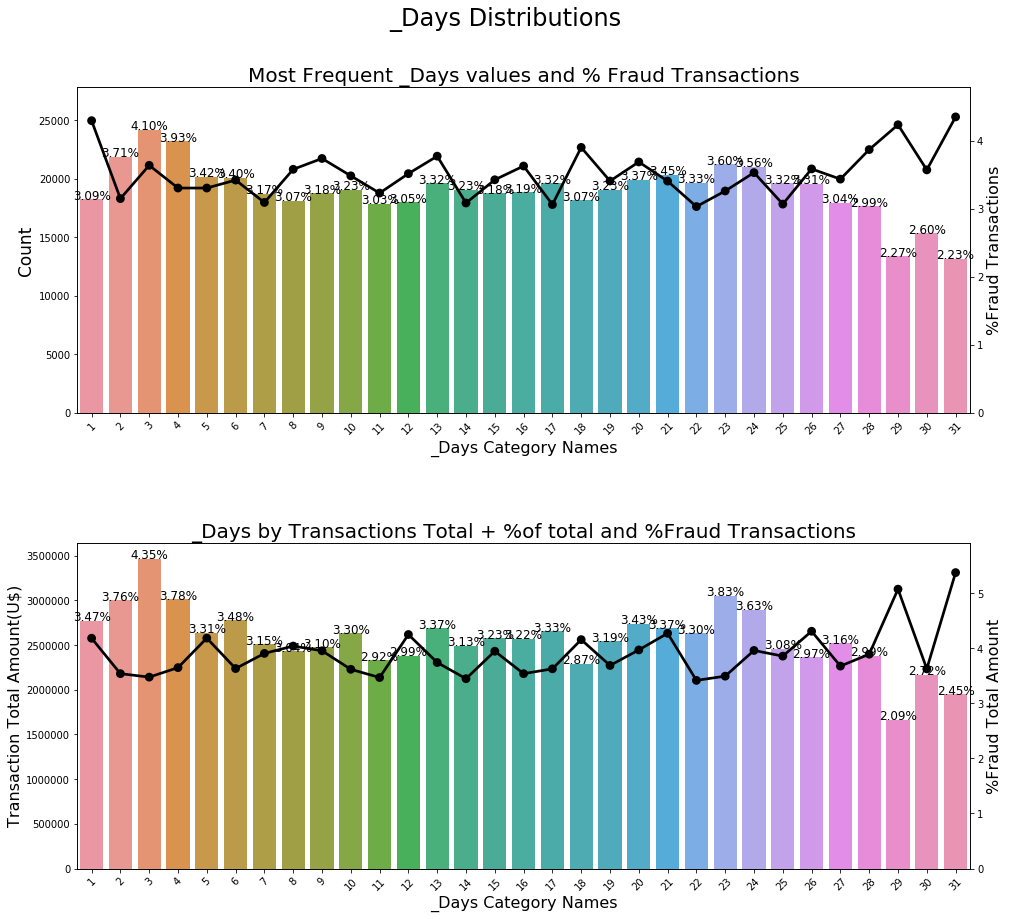

In [37]:
ploting_cnt_amt(df_trans, '_Days')

### Ploting WeekDays Distributions

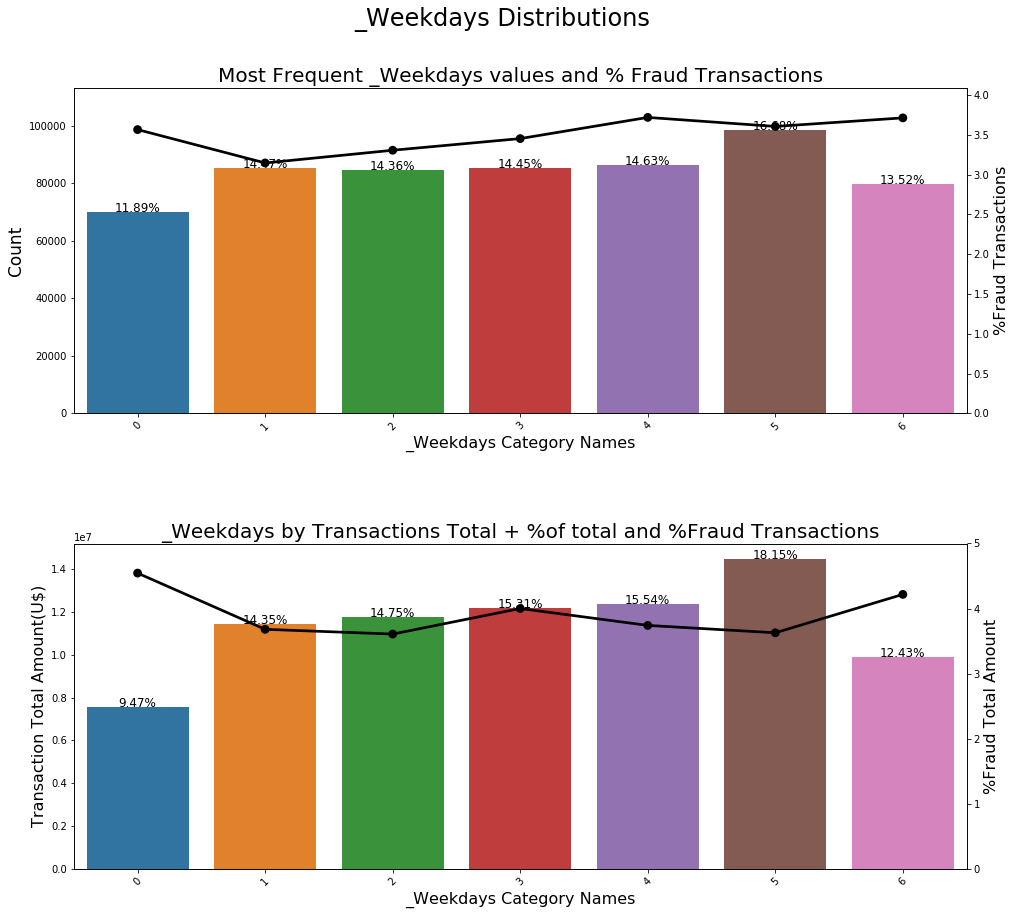

In [38]:
ploting_cnt_amt(df_trans, '_Weekdays')

We don't have the reference of date but we can see that two days has lower transactions, that we can infer it is weekend days

### Ploting Hours Distributions

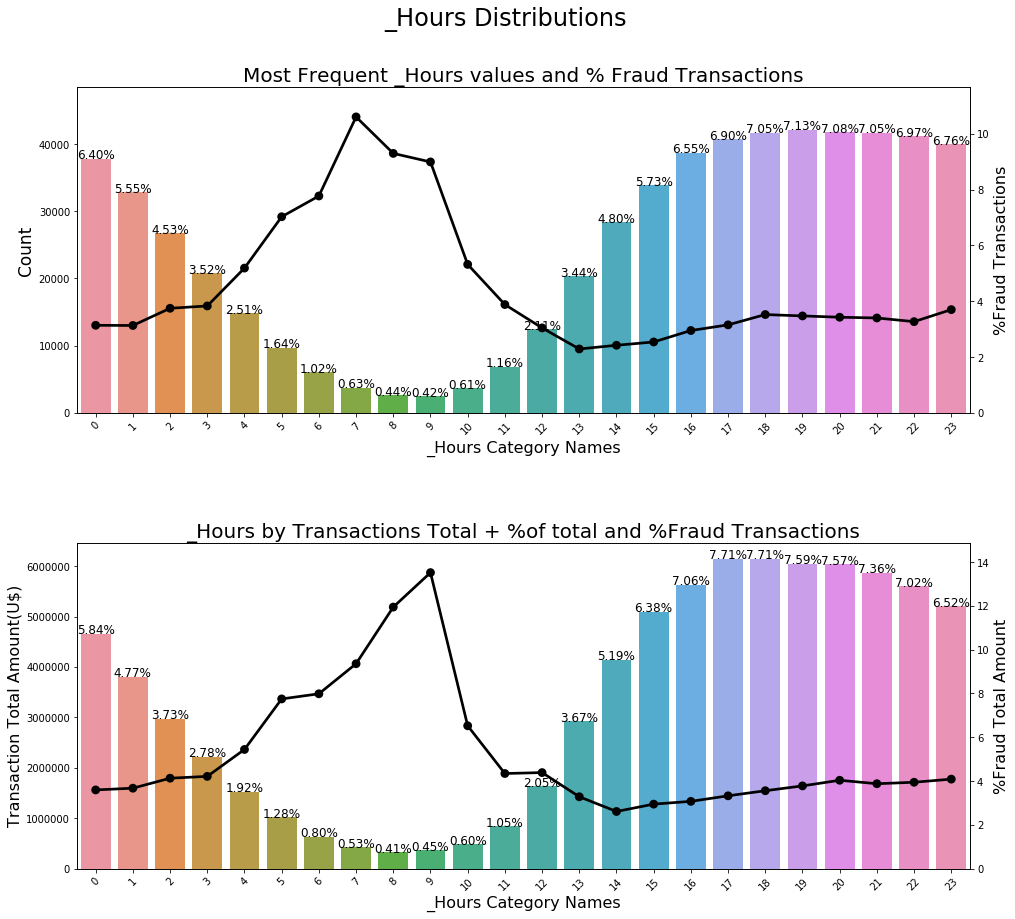

In [39]:
ploting_cnt_amt(df_trans, '_Hours')

### Transactions and Total Amount by each day

In [41]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to appropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt, opacity=0.8, line=dict(color=color_op[7]), name='Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

In [42]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

### Features [id_12 to id_38]

- categorical features in training identity dataset

In [43]:
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)

### Ploting columns with few unique values

In [47]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

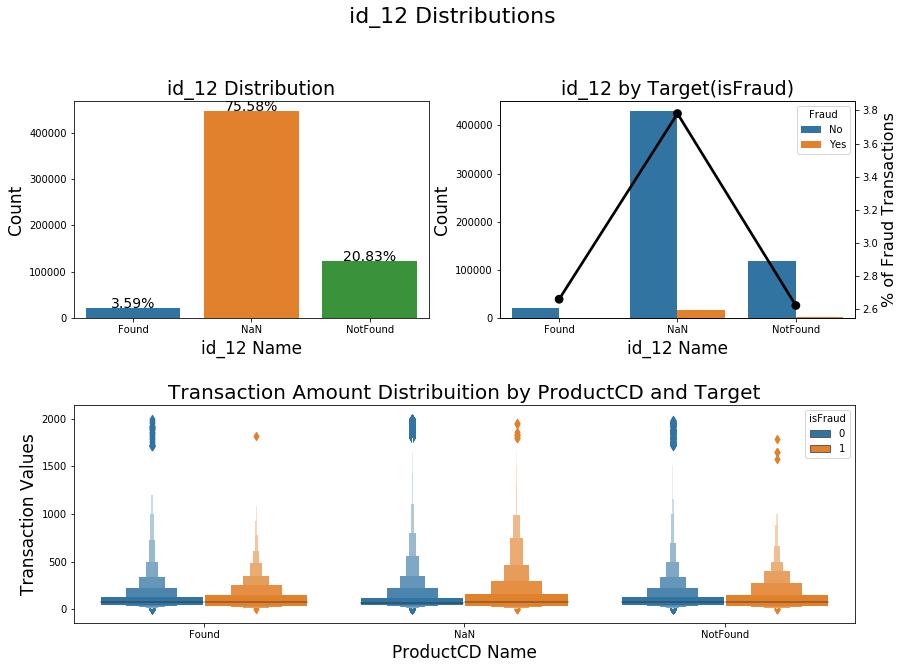

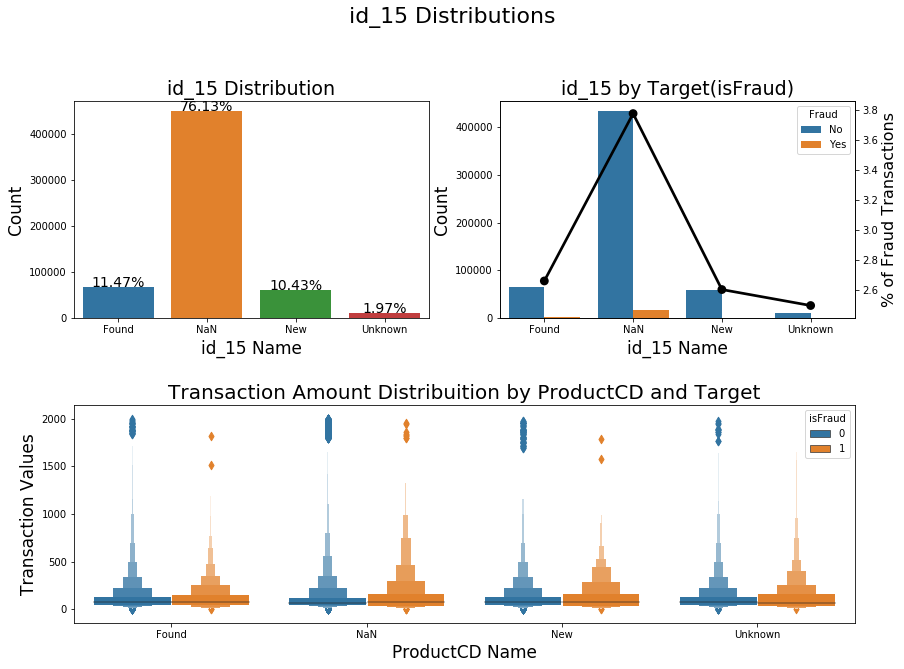

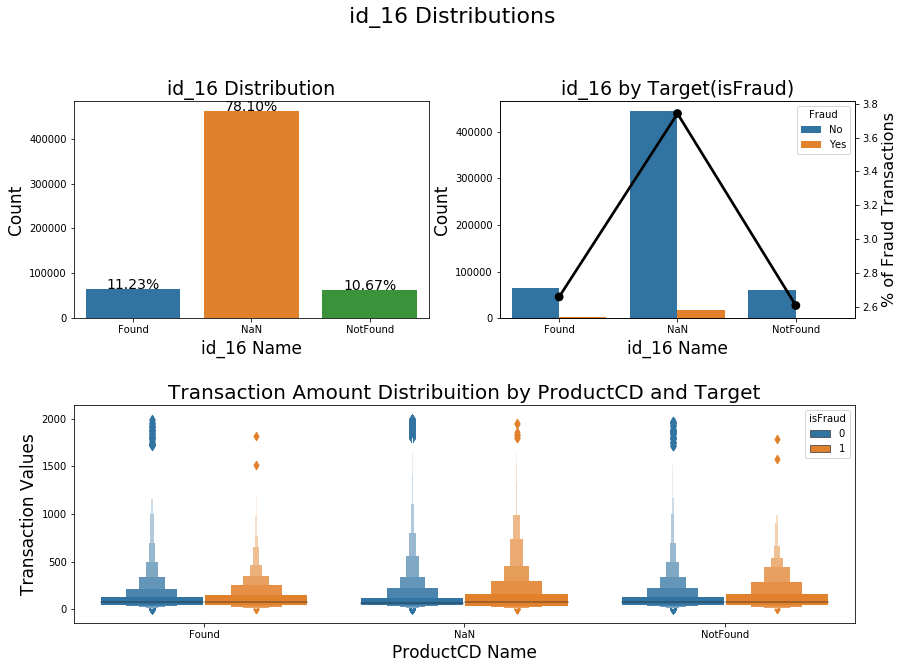

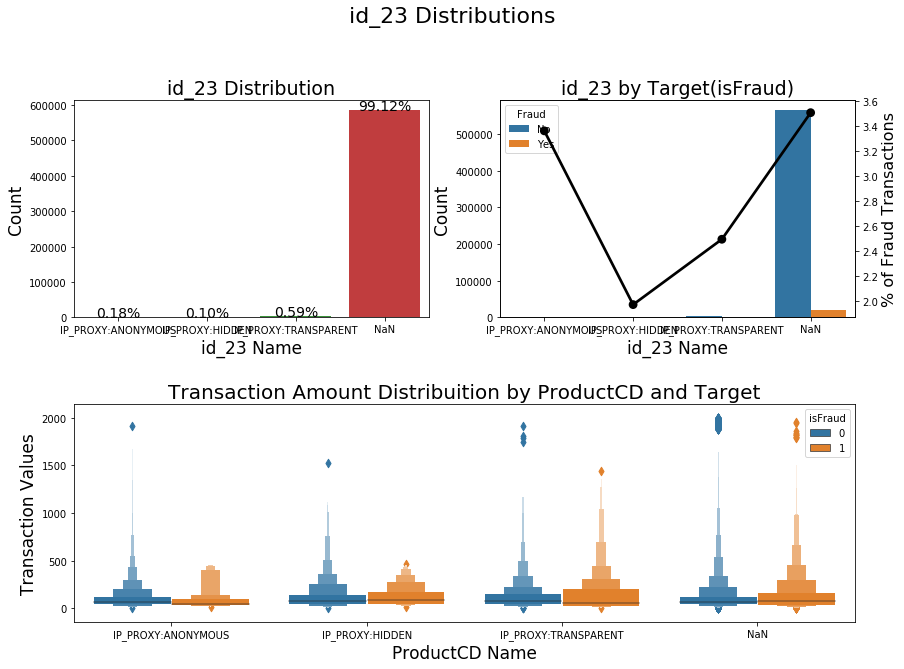

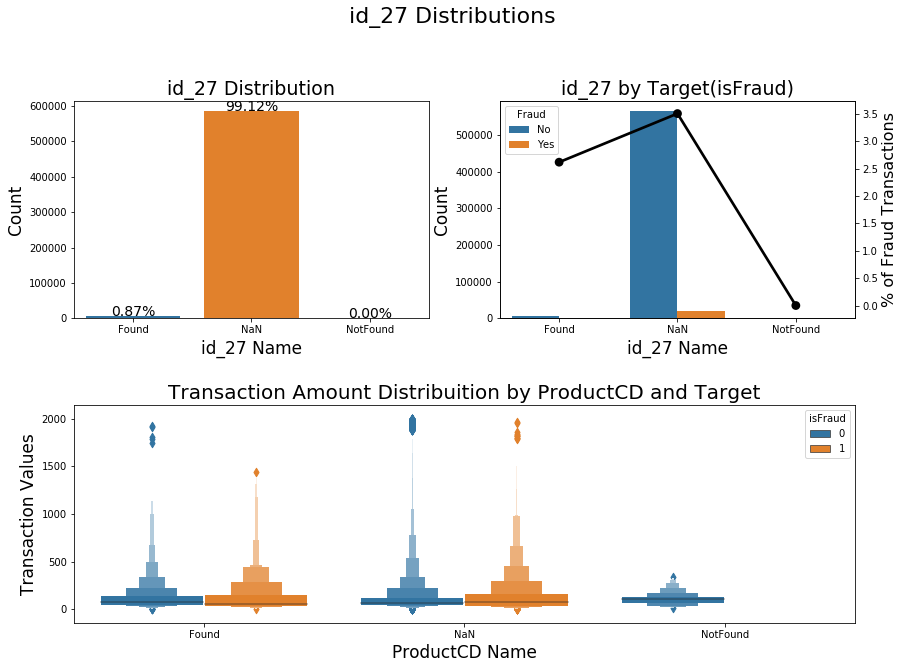

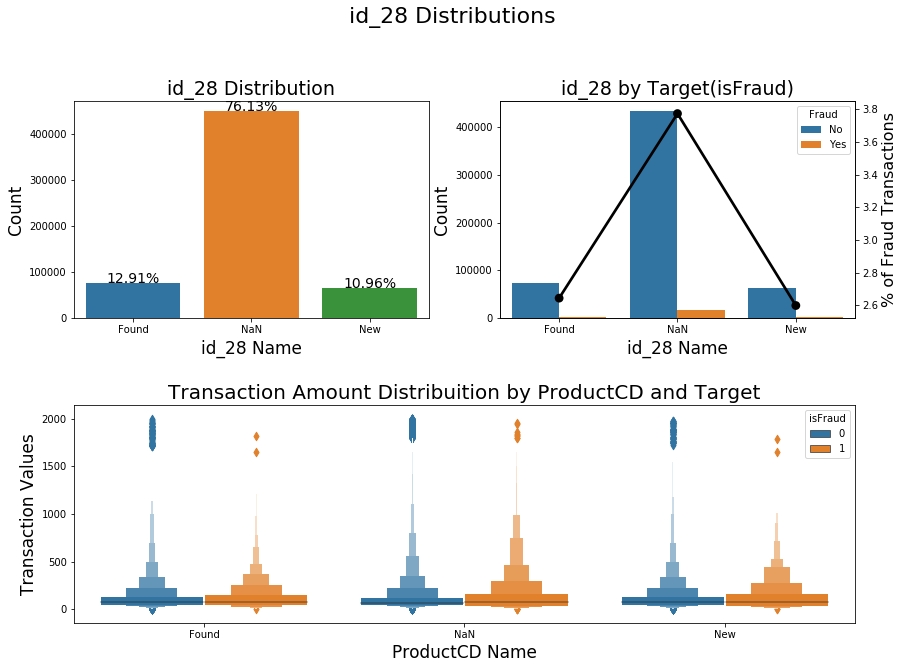

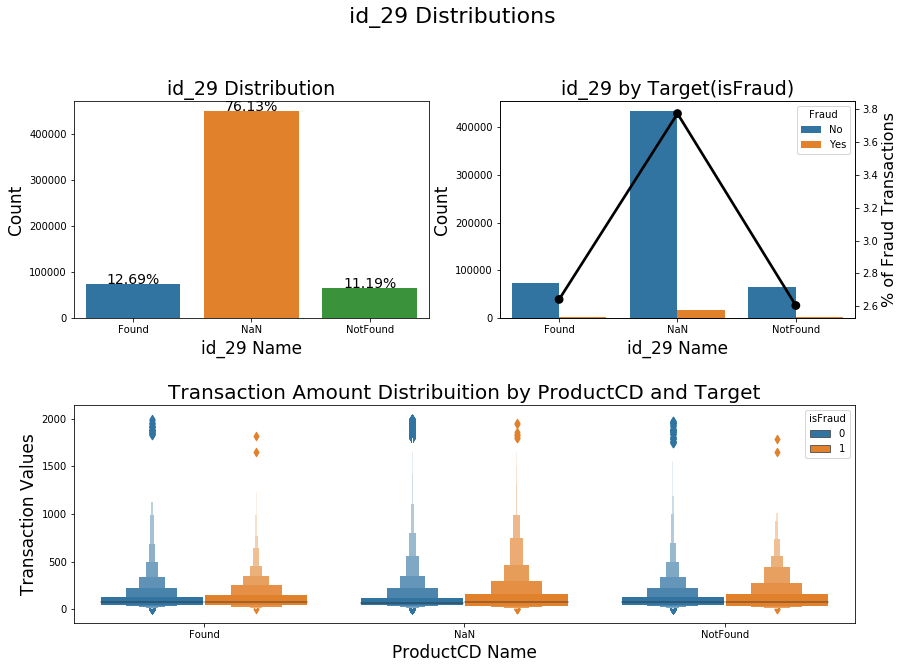

In [48]:
for col in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    df_train[col] = df_train[col].fillna('NaN')
    cat_feat_ploting(df_train, col)

### Id_30

In [49]:
df_train.loc[df_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train['id_30'].fillna("NAN", inplace=True)

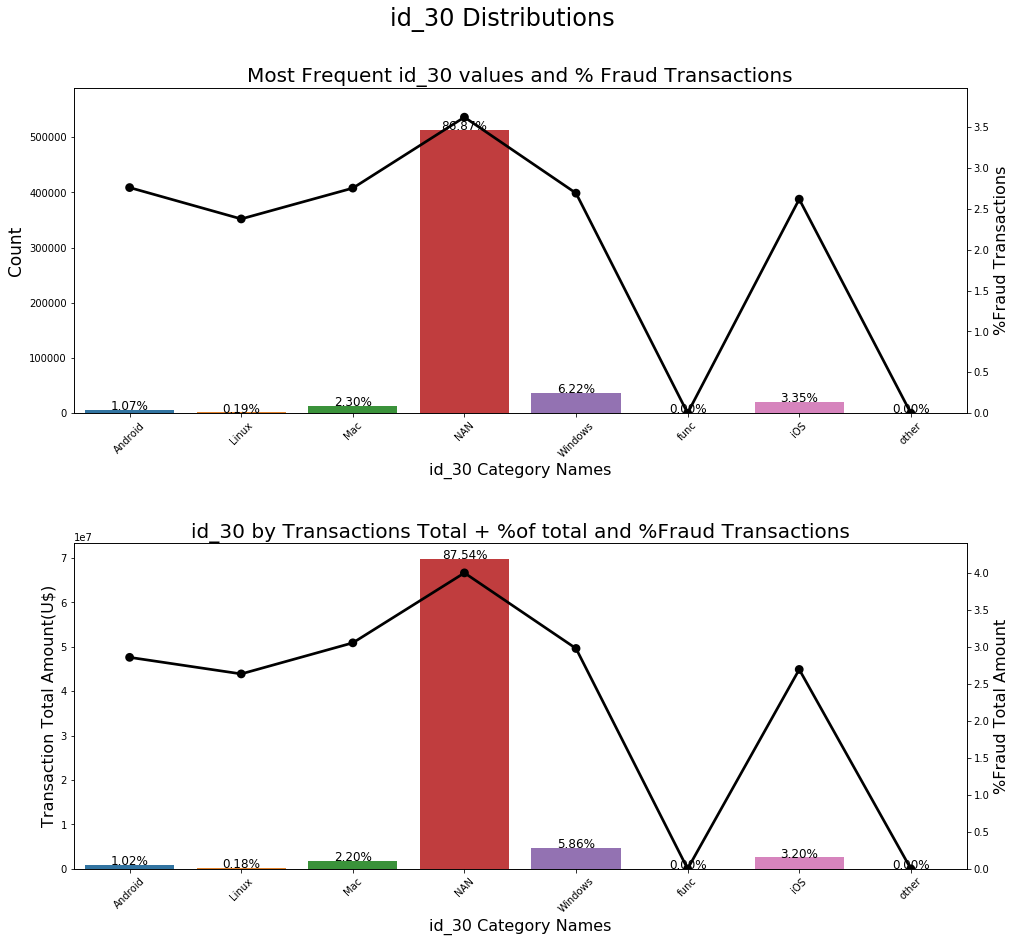

In [50]:
ploting_cnt_amt(df_train, 'id_30')

### Id_31

In [51]:
df_train.loc[df_train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df_train['id_31'].fillna("NAN", inplace=True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

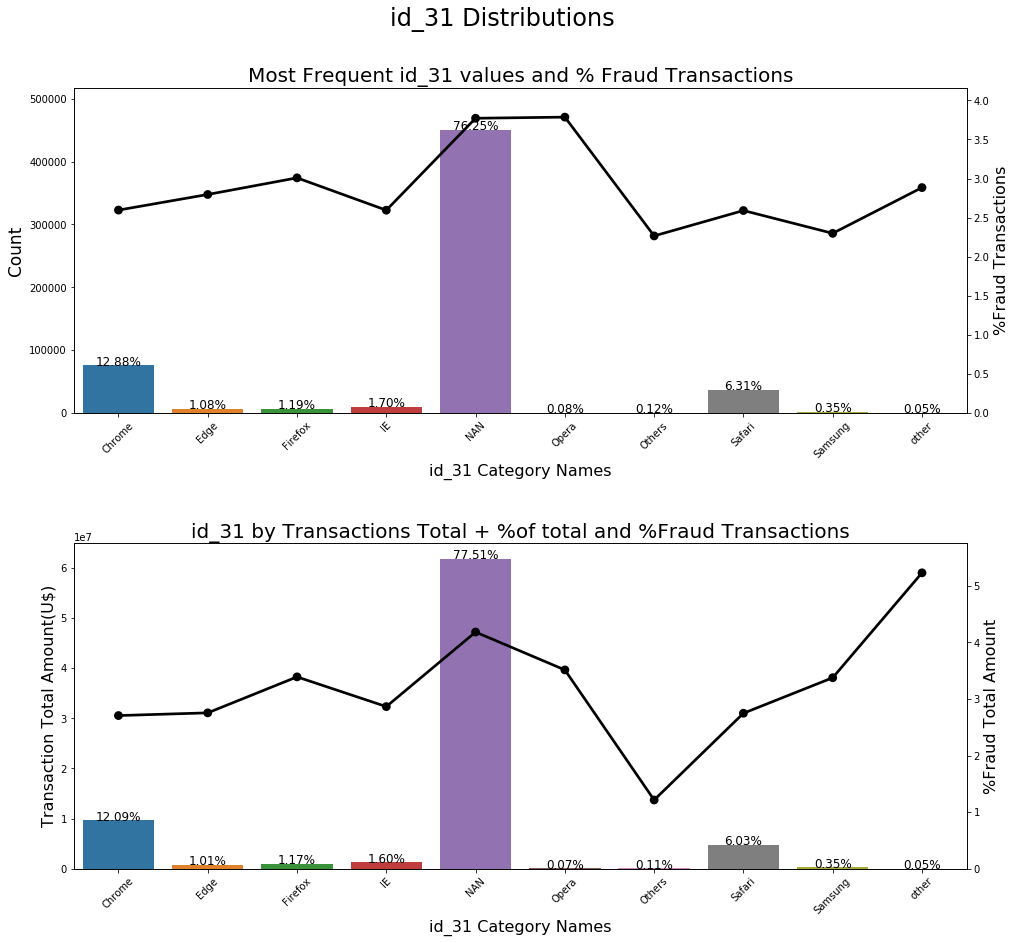

In [52]:
ploting_cnt_amt(df_train, 'id_31')